### Estimation of obesity levels based on eating habits and physical condition

In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import statistics 
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [5]:
df= pd.read_csv(r'C:\Users\Maedeh\Downloads\ObesityDataSet_raw_and_data_sinthetic.csv')

In [6]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


The dataset contains 16 variables. 15 features:
Gender
Age
Height
Weight
Family History with Overweight
Attributes related with eating habits (6)
Attributes related with the physical condition (4)
1 target:
NObeyesdad, renamed NObesity
Another revelant information is that most of these variables are category, except for Age, Height and Weight.

we want to classify individuals according to their obesity level which will be named: NObesity
There are 7 variables:
Insufficient_Weight/
Normal_Weight/
Overweight_Level_I/
Overweight_Level_II/
Obesity_Type_I/
Obesity_Type_II/
Obesity_Type_III

### Data Cleaning

In [7]:
df_clean = df.dropna()
print(df_clean.shape, df.shape)

(2111, 17) (2111, 17)


#### there is no missing value in our dataset!

We will check if we have outliers for non-categorical variables(Age, Height and Weight) or not. The study has been done with subjects between 14 and 61, so there is not a problem with it.

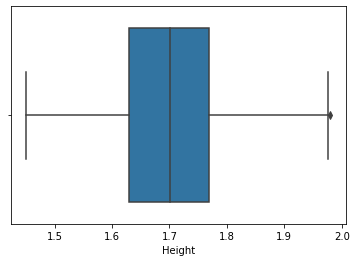

In [8]:
sns.boxplot(x=df['Height'])

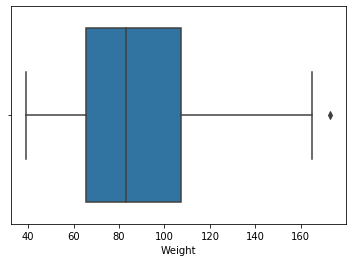

In [9]:
sns.boxplot(x=df['Weight'])

we will exclude the extreme values by using quantile values.

In [10]:
df_categorized = df.copy()

In [11]:
q1, q2 = df_categorized["Height"].quantile(q=0.25), df_categorized["Height"].quantile(q=0.75)
q3, q4 = df_categorized["Weight"].quantile(q=0.25), df_categorized["Weight"].quantile(q=0.75)

IQR1, IQR2 = q2-q1, q4-q3

#Height selection
df_categorized = df_categorized[df_categorized["Height"] >  q1 - 1.5*IQR1]
df_categorized = df_categorized[df_categorized["Height"] <  q2 + 1.5*IQR1]

#Weight selection
df_categorized = df_categorized[df_categorized["Weight"] >  q3 - 1.5*IQR2]
df_categorized = df_categorized[df_categorized["Weight"] <  q4 + 1.5*IQR2]

df_categorized.shape

(2109, 17)

3 lines were deleted.

In [12]:
df.describe().T.style.bar(subset=['mean'], color='#606ff2').background_gradient(subset=['std'], cmap='Blues').background_gradient(subset=['50%'], cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
Age,2111,24.3126,6.34597,14,19.9472,22.7779,26,61
Height,2111,1.70168,0.0933048,1.45,1.63,1.7005,1.76846,1.98
Weight,2111,86.5861,26.1912,39,65.4733,83,107.431,173
FCVC,2111,2.41904,0.533927,1,2,2.3855,3,3
NCP,2111,2.68563,0.778039,1,2.65874,3,3,4
CH2O,2111,2.00801,0.612953,1,1.58481,2,2.47742,3
FAF,2111,1.0103,0.850592,0,0.124505,1,1.66668,3
TUE,2111,0.657866,0.608927,0,0,0.62535,1,2


In [13]:
target = pd.DataFrame(df_categorized, columns = ['NObeyesdad'])

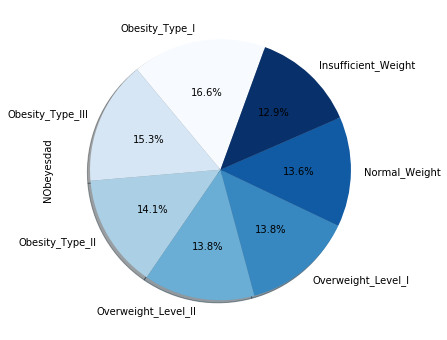

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
target['NObeyesdad'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, cmap="Blues", startangle=70)

In [15]:
list_var = ['Gender','family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
for x in list_var:
    print(df_categorized[x].unique())

['Female' 'Male']
['yes' 'no']
['no' 'yes']
['Sometimes' 'Frequently' 'Always' 'no']
['no' 'yes']
['no' 'yes']
['no' 'Sometimes' 'Frequently' 'Always']
['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']


In [16]:
dict_Gender = {'Female' : 0, 'Male' : 1}
dict_family_history_with_overweight = {'no' : 0, 'yes' : 1}
dict_FAVC = {'no' : 0, 'yes' : 1}
dict_CAEC = {'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3}
dict_SMOKE = {'no' : 0, 'yes' : 1}
dict_SCC = {'no' : 0, 'yes' : 1}
dict_CALC = {'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3}
dict_MTRANS = {'Public_Transportation' : 0, 'Walking' : 1, 'Automobile' : 2, 'Motorbike' : 3, 'Bike' : 4}
dict_NObeyesdad = {'Normal_Weight' : 0, 'Overweight_Level_I' : 1, 'Overweight_Level_II' : 2, 'Obesity_Type_I' : 3, 'Insufficient_Weight' : 4, 'Obesity_Type_II' : 5, 'Obesity_Type_III' : 6,}

In [17]:
for x in list_var:
    exec("df_categorized['"+ x +"'] = df_categorized['"+ x +"'].replace(dict_"+ x +")") #transformation for each string variable

df_categorized.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,0,Normal_Weight
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,0,Normal_Weight
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,0,Normal_Weight
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,1,Overweight_Level_I
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,0,Overweight_Level_II


### Data Processing

In [18]:
df_features = df_categorized.drop(columns = 'NObeyesdad')

In [19]:
scaler = preprocessing.StandardScaler().fit(df_features)
df_scaled = pd.DataFrame(scaler.transform(df_features))
df_scaled['NObesity'] = df['NObeyesdad']
df_scaled.columns = df.columns.to_list()
df_scaled.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,-1.010966,-0.522851,-0.875432,-0.862561,0.472565,-2.75829,-0.784838,0.404376,-0.29881,-0.145971,-0.012314,-0.218380,-1.187312,0.562347,-1.418188,-0.562843,Normal_Weight
1,-1.010966,-0.522851,-1.950036,-1.168884,0.472565,-2.75829,1.088434,0.404376,-0.29881,6.850680,1.619759,4.579165,2.339939,-1.079742,0.521474,-0.562843,Normal_Weight
2,0.989153,-0.207656,1.058855,-0.364787,0.472565,-2.75829,-0.784838,0.404376,-0.29881,-0.145971,-0.012314,-0.218380,1.164189,0.562347,2.461135,-0.562843,Normal_Weight
3,0.989153,0.422733,1.058855,0.018116,-2.116110,-2.75829,1.088434,0.404376,-0.29881,-0.145971,-0.012314,-0.218380,1.164189,-1.079742,2.461135,0.588501,Overweight_Level_I
4,0.989153,-0.365253,0.843934,0.125329,-2.116110,-2.75829,-0.784838,-2.165781,-0.29881,-0.145971,-0.012314,-0.218380,-1.187312,-1.079742,0.521474,-0.562843,Overweight_Level_II


In [20]:
df_scaled_features = df_scaled.drop(columns = 'NObeyesdad')
X_train, X_test, Y_train, Y_test = train_test_split(df_scaled_features, df_scaled['NObeyesdad'], test_size=0.33)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

### KNN

In [22]:
%%time
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train,Y_train).predict(X_test)
pred_knn1 = knn1.predict(X_test)

Wall time: 87.8 ms


In [23]:
acc_knn1 = cross_val_score(knn1, X_test, Y_test, cv=3, scoring='accuracy')
acc_knn1
print(acc_knn1.mean())
print(acc_knn1.std())

0.7198597823070713
0.017540982060015853


In [24]:
precision_knn1 = cross_val_score(knn1, X_test, Y_test, cv=3, scoring='precision_macro')
precision_knn1
print(precision_knn1.mean())
print(precision_knn1.std())

0.7124225249509619
0.021963050087500987


In [25]:
recall_knn1 = cross_val_score(knn1, X_test, Y_test, cv=3, scoring='recall_macro')
recall_knn1
print(recall_knn1.mean())
print(recall_knn1.std())

0.7238281445318209
0.018279593070919073


In [26]:
f1_knn1 = cross_val_score(knn1, X_test, Y_test, cv=3, scoring='f1_macro')
f1_knn1
print(f1_knn1.mean())
print(f1_knn1.std())

0.713418152718129
0.02204126210797353


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test, pred_knn1))
print(classification_report(Y_test, pred_knn1))

[[ 71  11   0   0   0   2   2]
 [ 13  52   8   2   1  12  19]
 [  1   4  89   3   0   2   4]
 [  0   0   2  87   1   0   2]
 [  2   0   0   1 105   0   0]
 [  1   4   8   3   0  68  11]
 [  0   9   6   3   0   8  79]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.81      0.83      0.82        86
      Normal_Weight       0.65      0.49      0.56       107
     Obesity_Type_I       0.79      0.86      0.82       103
    Obesity_Type_II       0.88      0.95      0.91        92
   Obesity_Type_III       0.98      0.97      0.98       108
 Overweight_Level_I       0.74      0.72      0.73        95
Overweight_Level_II       0.68      0.75      0.71       105

           accuracy                           0.79       696
          macro avg       0.79      0.79      0.79       696
       weighted avg       0.79      0.79      0.79       696



In [28]:
%%time
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train,Y_train).predict(X_test)
pred_knn3 = knn3.predict(X_test)

Wall time: 77.8 ms


In [29]:
acc_knn3 = cross_val_score(knn3, X_test, Y_test, cv=3, scoring='accuracy')
acc_knn3
print(acc_knn3.mean())
print(acc_knn3.std())

0.6925209790719471
0.011102859979877457


In [30]:
precision_knn3 = cross_val_score(knn3, X_test, Y_test, cv=3, scoring='precision_macro')
precision_knn3
print(precision_knn3.mean())
print(precision_knn3.std())

0.6862118542187994
0.015193185307423581


In [31]:
recall_knn3 = cross_val_score(knn3, X_test, Y_test, cv=3, scoring='recall_macro')
recall_knn3
print(recall_knn3.mean())
print(recall_knn3.std())

0.6978385770944145
0.010892203682871821


In [32]:
f1_knn3 = cross_val_score(knn3, X_test, Y_test, cv=3, scoring='f1_macro')
f1_knn3
print(f1_knn3.mean())
print(f1_knn3.std())

0.6844912337215759
0.012826831439226643


In [33]:
print(confusion_matrix(Y_test, pred_knn3))
print(classification_report(Y_test, pred_knn3))

[[ 76   7   1   0   0   2   0]
 [ 29  48   9   2   1  10   8]
 [  3   6  86   3   1   1   3]
 [  0   0   1  89   1   1   0]
 [  2   0   0   1 105   0   0]
 [  4   7  10   3   0  67   4]
 [  2  11   6   6   0   6  74]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.66      0.88      0.75        86
      Normal_Weight       0.61      0.45      0.52       107
     Obesity_Type_I       0.76      0.83      0.80       103
    Obesity_Type_II       0.86      0.97      0.91        92
   Obesity_Type_III       0.97      0.97      0.97       108
 Overweight_Level_I       0.77      0.71      0.74        95
Overweight_Level_II       0.83      0.70      0.76       105

           accuracy                           0.78       696
          macro avg       0.78      0.79      0.78       696
       weighted avg       0.78      0.78      0.78       696



In [34]:
%%time
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train,Y_train).predict(X_test)
pred_knn5 = knn5.predict(X_test)

Wall time: 85.8 ms


In [35]:
acc_knn5 = cross_val_score(knn5, X_test, Y_test, cv=3, scoring='accuracy')
acc_knn5
print(acc_knn5.mean())
print(acc_knn5.std())

0.6953011289274572
0.011504040055152225


In [36]:
precision_knn5 = cross_val_score(knn5, X_test, Y_test, cv=3, scoring='precision_macro')
precision_knn5
print(precision_knn5.mean())
print(precision_knn5.std())

0.6927678857497126
0.011780100451351149


In [37]:
recall_knn5 = cross_val_score(knn5, X_test, Y_test, cv=3, scoring='recall_macro')
recall_knn5
print(recall_knn5.mean())
print(recall_knn5.std())

0.7004080003030752
0.012202966400704696


In [38]:
f1_knn5 = cross_val_score(knn5, X_test, Y_test, cv=3, scoring='f1_macro')
f1_knn5
print(f1_knn5.mean())
print(f1_knn5.std())

0.6880336295471957
0.014273735646573443


In [39]:
print(confusion_matrix(Y_test, pred_knn5))
print(classification_report(Y_test, pred_knn5))

[[ 74   8   1   0   0   2   1]
 [ 26  44  11   3   1  15   7]
 [  3   1  85   5   2   2   5]
 [  0   0   0  90   1   1   0]
 [  1   0   0   1 105   1   0]
 [  4   5  13   2   0  67   4]
 [  0   7   8   8   0  11  71]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.69      0.86      0.76        86
      Normal_Weight       0.68      0.41      0.51       107
     Obesity_Type_I       0.72      0.83      0.77       103
    Obesity_Type_II       0.83      0.98      0.90        92
   Obesity_Type_III       0.96      0.97      0.97       108
 Overweight_Level_I       0.68      0.71      0.69        95
Overweight_Level_II       0.81      0.68      0.74       105

           accuracy                           0.77       696
          macro avg       0.77      0.78      0.76       696
       weighted avg       0.77      0.77      0.76       696



In [40]:
error = []
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != Y_test))

Text(0, 0.5, 'Mean Error')

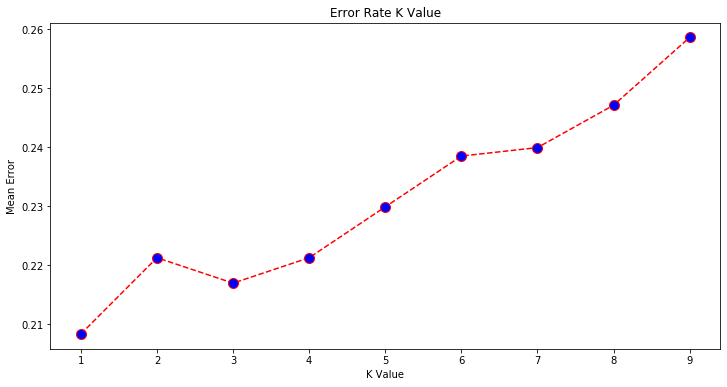

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 10), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

### Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier

In [43]:
%%time
from sklearn.metrics import accuracy_score
dtree1 = DecisionTreeClassifier(criterion='gini')
dtree1.fit(X_train, Y_train).predict(X_test)
pred_gini = dtree1.predict(X_test)

Wall time: 24.9 ms


In [44]:
acc_dtree1 = accuracy_score(Y_test, pred_gini)
acc_dtree1

0.6982758620689655

In [45]:
acc_dtree1 = cross_val_score(dtree1, X_test, Y_test, cv=3, scoring='accuracy')
acc_dtree1
print(acc_dtree1.mean())
print(acc_dtree1.std())

0.597821762533047
0.012957619824163288


In [46]:
precision_dtree1 = cross_val_score(dtree1, X_test, Y_test, cv=3, scoring='precision_macro')
precision_dtree1
print(precision_dtree1.mean())
print(precision_dtree1.std())

0.5726030731767855
0.012934995795039575


In [47]:
recall_dtree1 = cross_val_score(dtree1, X_test, Y_test, cv=3, scoring='recall_macro')
recall_dtree1
print(recall_dtree1.mean())
print(recall_dtree1.std())

0.6057665789712252
0.022506746080076735


In [48]:
f1_dtree1 = cross_val_score(dtree1, X_test, Y_test, cv=3, scoring='f1_macro')
f1_dtree1
print(f1_dtree1.mean())
print(f1_dtree1.std())

0.5857115805075268
0.016912010675149636


In [49]:
print(confusion_matrix(Y_test, pred_gini))
print(classification_report(Y_test, pred_gini))

[[ 63  12   1   1   0   4   5]
 [ 15  49   7   0   2  19  15]
 [  2   7  66   7   0  15   6]
 [  0   0   4  81   1   1   5]
 [  3   0   1   0 103   0   1]
 [  2  13   5   2   1  63   9]
 [  0   9  16   5   0  14  61]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.74      0.73      0.74        86
      Normal_Weight       0.54      0.46      0.50       107
     Obesity_Type_I       0.66      0.64      0.65       103
    Obesity_Type_II       0.84      0.88      0.86        92
   Obesity_Type_III       0.96      0.95      0.96       108
 Overweight_Level_I       0.54      0.66      0.60        95
Overweight_Level_II       0.60      0.58      0.59       105

           accuracy                           0.70       696
          macro avg       0.70      0.70      0.70       696
       weighted avg       0.70      0.70      0.70       696



In [50]:
%%time
dtree2 = DecisionTreeClassifier(criterion='entropy')
dtree2.fit(X_train, Y_train).predict(X_test)
pred_entropy = dtree2.predict(X_test)

Wall time: 54.8 ms


In [51]:
acc_dtree2 = cross_val_score(dtree2, X_test, Y_test, cv=3, scoring='accuracy')
acc_dtree2
print(acc_dtree2.mean())
print(acc_dtree2.std())

0.5992029338263197
0.011540643409233933


In [52]:
precision_dtree2 = cross_val_score(dtree2, X_test, Y_test, cv=3, scoring='precision_macro')
precision_dtree2
print(precision_dtree2.mean())
print(precision_dtree2.std())

0.6195888069978854
0.02928966208013753


In [53]:
recall_dtree2 = cross_val_score(dtree2, X_test, Y_test, cv=3, scoring='recall_macro')
recall_dtree2
print(recall_dtree2.mean())
print(recall_dtree2.std())

0.5955012041276775
0.03323018742237384


In [54]:
f1_dtree2 = cross_val_score(dtree2, X_test, Y_test, cv=3, scoring='f1_macro')
f1_dtree2
print(f1_dtree2.mean())
print(f1_dtree2.std())

0.5876360438966274
0.024049335052457984


In [55]:
print(confusion_matrix(Y_test, pred_entropy))
print(classification_report(Y_test, pred_entropy))

[[ 60  14   0   0   0   6   6]
 [  4  54   5   1   1  20  22]
 [  2   9  71   8   0  10   3]
 [  0   0   4  84   1   1   2]
 [  0   4   1   0 102   1   0]
 [  1  13  13   0   0  62   6]
 [  0  13  27   7   0  14  44]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.90      0.70      0.78        86
      Normal_Weight       0.50      0.50      0.50       107
     Obesity_Type_I       0.59      0.69      0.63       103
    Obesity_Type_II       0.84      0.91      0.87        92
   Obesity_Type_III       0.98      0.94      0.96       108
 Overweight_Level_I       0.54      0.65      0.59        95
Overweight_Level_II       0.53      0.42      0.47       105

           accuracy                           0.69       696
          macro avg       0.70      0.69      0.69       696
       weighted avg       0.69      0.69      0.68       696



### SVM

In [56]:
%%time
# RBF
from sklearn.svm import SVC
svc_rbf = SVC(kernel='rbf',random_state = 0)
svc_rbf.fit(X_train,Y_train).predict(X_test)
pred_rbf = svc_rbf.predict(X_test)

Wall time: 111 ms


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [57]:
acc_rbf = cross_val_score(svc_rbf, X_test, Y_test, cv=3, scoring='accuracy')
acc_rbf
print(acc_rbf.mean())
print(acc_rbf.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7012479558349828
0.010611987281280865


In [58]:
precision_rbf = cross_val_score(svc_rbf, X_test, Y_test, cv=3, scoring='precision_macro')
precision_rbf
print(precision_rbf.mean())
print(precision_rbf.std())

0.7059875570755136
0.011934069073871303


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [59]:
recall_rbf = cross_val_score(svc_rbf, X_test, Y_test, cv=3, scoring='recall_macro')
recall_rbf
print(recall_rbf.mean())
print(recall_rbf.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7021148278245916
0.01106090035516693


In [60]:
f1_rbf = cross_val_score(svc_rbf, X_test, Y_test, cv=3, scoring='f1_macro')
f1_rbf
print(f1_rbf.mean())
print(f1_rbf.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.6997979880999926
0.007071299275657687


In [61]:
print(confusion_matrix(Y_test, pred_rbf))
print(classification_report(Y_test, pred_rbf))

[[ 73  11   1   0   0   1   0]
 [ 17  70   2   0   0  11   7]
 [  1   9  85   5   0   0   3]
 [  0   1   2  87   1   0   1]
 [  2   1   0   0 105   0   0]
 [  1  11  11   1   0  67   4]
 [  0   6  14   4   0  16  65]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.78      0.85      0.81        86
      Normal_Weight       0.64      0.65      0.65       107
     Obesity_Type_I       0.74      0.83      0.78       103
    Obesity_Type_II       0.90      0.95      0.92        92
   Obesity_Type_III       0.99      0.97      0.98       108
 Overweight_Level_I       0.71      0.71      0.71        95
Overweight_Level_II       0.81      0.62      0.70       105

           accuracy                           0.79       696
          macro avg       0.79      0.80      0.79       696
       weighted avg       0.80      0.79      0.79       696



In [62]:
%%time
#poly
svc_poly = svm.SVC(kernel='poly')
svc_poly.fit(X_train, Y_train).predict(X_test)
pred_poly= svc_poly.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 93.8 ms


In [63]:
acc_poly = cross_val_score(svc_poly, X_test, Y_test, cv=3, scoring='accuracy')
acc_poly
print(acc_poly.mean())
print(acc_poly.std())

0.6937833195493859
0.020369035943617494


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [64]:
precision_poly = cross_val_score(svc_poly, X_test, Y_test, cv=3, scoring='precision_macro')
precision_poly
print(precision_poly.mean())
print(precision_poly.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7001263502438775
0.01987778982844172


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [65]:
recall_poly = cross_val_score(svc_poly, X_test, Y_test, cv=3, scoring='recall_macro')
recall_poly
print(recall_poly.mean())
print(recall_poly.std())

0.6973426931024541
0.02085795520892271


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [66]:
f1_poly = cross_val_score(svc_poly, X_test, Y_test, cv=3, scoring='f1_macro')
f1_poly
print(f1_poly.mean())
print(f1_poly.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.6901829966168401
0.022934134234860994


In [67]:
print(confusion_matrix(Y_test, pred_entropy))
print(classification_report(Y_test, pred_entropy))

[[ 60  14   0   0   0   6   6]
 [  4  54   5   1   1  20  22]
 [  2   9  71   8   0  10   3]
 [  0   0   4  84   1   1   2]
 [  0   4   1   0 102   1   0]
 [  1  13  13   0   0  62   6]
 [  0  13  27   7   0  14  44]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.90      0.70      0.78        86
      Normal_Weight       0.50      0.50      0.50       107
     Obesity_Type_I       0.59      0.69      0.63       103
    Obesity_Type_II       0.84      0.91      0.87        92
   Obesity_Type_III       0.98      0.94      0.96       108
 Overweight_Level_I       0.54      0.65      0.59        95
Overweight_Level_II       0.53      0.42      0.47       105

           accuracy                           0.69       696
          macro avg       0.70      0.69      0.69       696
       weighted avg       0.69      0.69      0.68       696



In [68]:
%%time
#sigmoid
svc_sigmoid = svm.SVC(kernel='sigmoid')
svc_sigmoid.fit(X_train, Y_train).predict(X_test)
pred_sigmoid= svc_sigmoid.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 131 ms


In [69]:
acc_sig = cross_val_score(svc_sigmoid, X_test, Y_test, cv=3, scoring='accuracy')
acc_sig
print(acc_sig.mean())
print(acc_sig.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5272890923883297
0.009600656390497437


In [70]:
precision_sig = cross_val_score(svc_sigmoid, X_test, Y_test, cv=3, scoring='precision_macro')
precision_sig
print(precision_sig.mean())
print(precision_sig.std())

0.514406905377803
0.008995330867756415


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [71]:
recall_sig = cross_val_score(svc_sigmoid, X_test, Y_test, cv=3, scoring='recall_macro')
recall_sig
print(recall_sig.mean())
print(recall_sig.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5283094228916384
0.01325251037995579


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [72]:
f1_sig = cross_val_score(svc_sigmoid, X_test, Y_test, cv=3, scoring='f1_macro')
f1_sig
print(f1_sig.mean())
print(f1_sig.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5147128462241742
0.010677869867608087


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [73]:
print(confusion_matrix(Y_test, pred_entropy))
print(classification_report(Y_test, pred_entropy))

[[ 60  14   0   0   0   6   6]
 [  4  54   5   1   1  20  22]
 [  2   9  71   8   0  10   3]
 [  0   0   4  84   1   1   2]
 [  0   4   1   0 102   1   0]
 [  1  13  13   0   0  62   6]
 [  0  13  27   7   0  14  44]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.90      0.70      0.78        86
      Normal_Weight       0.50      0.50      0.50       107
     Obesity_Type_I       0.59      0.69      0.63       103
    Obesity_Type_II       0.84      0.91      0.87        92
   Obesity_Type_III       0.98      0.94      0.96       108
 Overweight_Level_I       0.54      0.65      0.59        95
Overweight_Level_II       0.53      0.42      0.47       105

           accuracy                           0.69       696
          macro avg       0.70      0.69      0.69       696
       weighted avg       0.69      0.69      0.68       696



### Naive Bayes

In [74]:
%%time
gnb = GaussianNB()
pred_gnb = gnb.fit(X_train, Y_train).predict(X_test)

Wall time: 6.98 ms


In [75]:
acc_NB = cross_val_score(gnb, X_test, Y_test, cv=3, scoring='accuracy')
acc_NB
print(acc_NB.mean())
print(acc_NB.std())

0.5919560160990526
0.006114579851317322


In [76]:
precision_NB = cross_val_score(gnb, X_test, Y_test, cv=3, scoring='precision_macro')
precision_NB
print(precision_NB.mean())
print(precision_NB.std())

0.5820223522676616
0.006798540269982028


In [77]:
recall_NB = cross_val_score(gnb, X_test, Y_test, cv=3, scoring='recall_macro')
recall_NB
print(recall_NB.mean())
print(recall_NB.std())

0.5947389198541856
0.006871515112075688


In [78]:
f1_NB = cross_val_score(gnb, X_test, Y_test, cv=3, scoring='f1_macro')
f1_NB
print(f1_NB.mean())
print(f1_NB.std())

0.5827610833032192
0.007930820604628309


In [79]:
print(confusion_matrix(Y_test, pred_gnb))
print(classification_report(Y_test, pred_gnb))

[[ 69   9   4   0   0   2   2]
 [ 22  48   8   0   0  17  12]
 [  2   7  69  16   1   5   3]
 [  1   1   9  79   1   0   1]
 [  1   1   1   0 105   0   0]
 [  8  13  35   2   0  34   3]
 [  1   7  54  10   0   7  26]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.66      0.80      0.73        86
      Normal_Weight       0.56      0.45      0.50       107
     Obesity_Type_I       0.38      0.67      0.49       103
    Obesity_Type_II       0.74      0.86      0.79        92
   Obesity_Type_III       0.98      0.97      0.98       108
 Overweight_Level_I       0.52      0.36      0.42        95
Overweight_Level_II       0.55      0.25      0.34       105

           accuracy                           0.62       696
          macro avg       0.63      0.62      0.61       696
       weighted avg       0.63      0.62      0.60       696



### Ensemble model : Adaboost

In [80]:
%%time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
clfa = AdaBoostClassifier(n_estimators = 5)
clfa.fit(X_train, Y_train).predict(X_test)

Wall time: 48.9 ms


array(['Obesity_Type_I', 'Obesity_Type_I', 'Obesity_Type_II',
       'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_I',
       'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_I',
       'Obesity_Type_I', 'Obesity_Type_I', 'Normal_Weight',
       'Obesity_Type_II', 'Obesity_Type_I', 'Obesity_Type_I',
       'Obesity_Type_I', 'Obesity_Type_I', 'Obesity_Type_I',
       'Obesity_Type_II', 'Obesity_Type_III', 'Obesity_Type_II',
       'Obesity_Type_II', 'Obesity_Type_I', 'Obesity_Type_I',
       'Obesity_Type_I', 'Obesity_Type_I', 'Obesity_Type_I',
       'Obesity_Type_III', 'Obesity_Type_I', 'Obesity_Type_I',
       'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_I',
       'Obesity_Type_I', 'Obesity_Type_I', 'Obesity_Type_I',
       'Obesity_Type_I', 'Obesity_Type_I', 'Obesity_Type_I',
       'Obesity_Type_III', 'Obesity_Type_I', 'Obesity_Type_III',
       'Obesity_Type_I', 'Obesity_Type_I', 'Normal_Weight',
       'Obesity_Type_I', 'Obesity_Type_I', 'Obesity_Type_I',
       'Obesit

In [81]:
acc_clfa = cross_val_score(clfa, X_test, Y_test, cv=3, scoring = 'accuracy')
acc_clfa
print(acc_clfa.mean())
print(acc_clfa.std())

0.2460516051984838
0.07197998274243422


In [82]:
precision_clfa = cross_val_score(clfa, X_test, Y_test, cv=3, scoring = 'precision_macro')
precision_clfa
print(precision_clfa.mean())
print(precision_clfa.std())

0.178609015233162
0.1133493741175769


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [83]:
recall_clfa = cross_val_score(clfa, X_test, Y_test, cv=3, scoring = 'recall_macro')
recall_clfa
print(recall_clfa.mean())
print(recall_clfa.std())

0.2404672263170501
0.0745120463462821


In [84]:
f1_clfa = cross_val_score(clfa, X_test, Y_test, cv=3, scoring = 'f1_macro')
f1_clfa
print(f1_clfa.mean())
print(f1_clfa.std())

0.16734272122237037
0.08970737085887961


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Compare Algorithms

In [85]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#prepare configuration for cross validation test harness
seed = 7
#prepare models
models = []
models.append(('1NN', KNeighborsClassifier(n_neighbors = 1)))
models.append(('3NN', KNeighborsClassifier(n_neighbors = 3)))
models.append(('5NN', KNeighborsClassifier(n_neighbors = 5)))
models.append(('CART', DecisionTreeClassifier(criterion = 'gini')))
models.append(('InfGain', DecisionTreeClassifier(criterion = 'entropy')))
models.append(('NB', GaussianNB()))
models.append(('RBF', SVC(kernel='rbf')))
models.append(('Poly', SVC(kernel='poly')))
models.append(('Sig', SVC(kernel='sigmoid')))
models.append(('AB', AdaBoostClassifier(n_estimators=5)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

In [86]:
for name, model in models:
    kfold = model_selection.KFold(n_splits=3, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_test, Y_test, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

1NN: 0.705460 (0.004064)
3NN: 0.688218 (0.010160)
5NN: 0.688218 (0.028447)
CART: 0.614943 (0.031544)
InfGain: 0.599138 (0.012689)
NB: 0.583333 (0.010752)
RBF: 0.716954 (0.010752)
Poly: 0.662356 (0.022351)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

Sig: 0.548851 (0.031544)
AB: 0.225575 (0.077533)


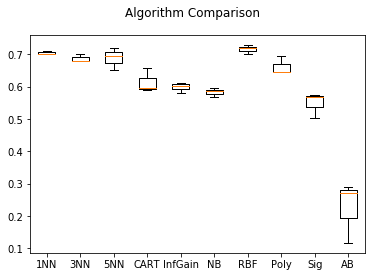

In [87]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()